#**Graded Challenge 2 Phase 1**
## **income Tax Bracket "Prediction" with Logistic Regression and Classification" with Support Vector Machine (SVM)**

Nadia Oktiarsy, FSDS Batch-016 RMT (Buddy: Dian)

---
```
Table of Contents:
1. Introduction
   1.1. Problem Statements
   1.2. Conceptual Problems
2. Importing Libraries
3. Data Loading
4. Exploratory Data Analysis (EDA)
   4.1. Basic Information
   4.2. Correlation Matrices
        4.2.1. Categorical Features
        4.2.2. Numerical Features
5. Data Preprocessing
   5.1. Data Inference
   5.2. Train and Test Set
   5.3. Data Skewness
   5.4. Outliers
   5.5. Features Selection
        5.5.1. Feature Scaling: Numerical
        5.5.2. Feature Encoding: Categorical
        5.5.3. Chi-square
   5.6. Final Result from Data Preprocessing
6. Model Definition
   6.1. Logistic Regression
   6.2. Support Vector Machine (SVM)
7. Model Training
   7.1. Logistic Regression
   7.2. Support Vector Machine (SVM)
8. Model Evalutation
   8.1. Logistic Regression
        8.1.1. Confusion Matrix
        8.1.2. Classification Report
        8.1.3. Area under the ROC Curve (AUC ROC)
   6.2. Support Vector Machine (SVM)
        8.2.1. Confusion Matrix
        8.2.2. Classification Report
        8.2.3. Cross-Validation
9. Model Inference
   9.1. Save and Load Model
   9.2. Features Selection
   9.3. Concatenante Scaled and Encoded Features
   9.4. Model Training Inference
   9.5. Summary from Model Inference
10. Conclusion
```

## **1. Introduction**
Income is important to predict taxes based on the backgrounds, meanwhile there are many backgrounds that each person has. We have to understand how people's backgrounds--such as gender, education, occupation, capital gain and loss, and many others--can influence income and taxes.

It is important to predict the taxes in the future with the current condition. Thus, the analysis for income tax bracket prediction will be discussed by using logistic regression and SVM.

### **1.1. Problem Statements**

To predict the income tax bracket (indicated by `income bracket`) using Logistic Regression, and to classify the income taxk bracket with model Classification SVM.

### **1.2. Conceptual Problems**

There are some questions that should be answered:
* What does it mean of coefficient in logistic regression?
* What does it mean of Support Vector in SVM?
* What are the parameters function from SVM's kernel? Explain one of kernels' definition and concept.

## **2. Importing Libraries**

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy import stats
import sys
import sklearn

# Data visualization libraries
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,8)

import warnings
warnings.filterwarnings('ignore')

# For Classification Problems
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Split Dataset and Standarize the Datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# Feature Selection
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif

# Evaluate Classification Models
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score

# Save and Load Model
import joblib
import json

# GoogleCloud Setup
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

project = 'hacktiv8-016-nadiaoktiarsy' # Project ID inserted based on the query results selected to explore
location = 'US'                        # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
auth.authenticate_user()

## **3. Data Loading**

The data loaded is based on dataset `ml_datasets` with name `census_adult_income`. The dataset is quaried on Google Cloud to study the contains, choose and clean the data that are needed. The data contains 30,162 rows and 14 columns with 5 columns are numerical and 9 columns are categorical.

We can see that apparently **there is no null value**, so for the next step in data preprocessing, missing value will be skipped. However, we should check the data skewness and outliers out before proceeding to model training.

In [2]:
# Creating query
df = client.query('''
SELECT
  age,
  LTRIM(workclass) AS workclass,
  LTRIM(education) AS education,
  education_num,
  LTRIM(marital_status) AS marital_status,
  LTRIM(occupation) AS occupation,
  LTRIM(relationship) AS relationship,
  LTRIM(race) AS race,
  LTRIM(sex) AS sex,
  capital_gain,
  capital_loss,
  hours_per_week,
  LTRIM(native_country) AS native_country,
  LTRIM(income_bracket) AS income_bracket
FROM `bigquery-public-data.ml_datasets.census_adult_income`
WHERE NOT workclass = " ?" AND
      NOT occupation = " ?" AND
      NOT native_country = " ?"
LIMIT 31888;
''').to_dataframe()

df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
1,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
2,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K
3,31,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,53,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,26,United-States,<=50K


In [3]:
df.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
30157,50,Self-emp-inc,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70,Germany,<=50K
30158,21,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,0,0,70,United-States,<=50K
30159,32,Private,Some-college,10,Separated,Machine-op-inspct,Unmarried,Black,Female,0,0,70,United-States,<=50K
30160,39,Private,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,70,United-States,<=50K
30161,20,Private,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,70,United-States,<=50K


In [4]:
## Downloading csv file
# from google.colab import files
# df.to_csv(r'h8dsft_P1G2_nadia_oktiarsy.csv')
# files.download(r'h8dsft_P1G2_nadia_oktiarsy.csv')

In [5]:
# Checking data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  Int64 
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education_num   30162 non-null  Int64 
 4   marital_status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital_gain    30162 non-null  Int64 
 10  capital_loss    30162 non-null  Int64 
 11  hours_per_week  30162 non-null  Int64 
 12  native_country  30162 non-null  object
 13  income_bracket  30162 non-null  object
dtypes: Int64(5), object(9)
memory usage: 3.4+ MB


In [6]:
# Checking missing values
df.isnull().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income_bracket    0
dtype: int64

**Data description:**

Header | Definition
---|---
`age` | Age
`workclass` | Nature of employment
`education` | Level of education completed
`education_num` | Estimated years of education completed based on the value of the education field.
`marital_status` | Marital status
`occupation` | Occupation category
`relationship` | Relationship to the household
`race` | Race
`sex` | Gender
`capital_gain` | Amount of capital gains, the profit earned on the sale of an asset which has increased in value over the holding period
`capital_loss` | Amount of capital loss, a lower selling price and a higher purchase price or cost price of an eligible Capital asset
`hours_per_week` | Hours worked per week
`native_country` | Country of birth
`income_bracket` | Either ">50K" or "<=50K" based on income.

## **4. Exploratory Data Analysis (EDA)**

The Exploratory Data Analysis will study about the basic information of the data before we proceed to data preprocessing. What we should observe are basically the correlation between `income_bracket` (that will be chosen as the target later) with categorical and numerical features.

### **4.1. Basic Information**

**Capital Gain and Loss based on Age**

Capital gains are generally included in taxable income, but in most cases, are taxed at a lower rate. we can see that the distribution of capital gain is almost distrubuted normally, where most people gain around `0 ~ 20,000` USD regardless their age.

Meanwhile, capital losses have a limited impact on earned income in subsequent tax years, but they can be fully applied against future capital gains. Based on the scatterplot, there is a dense distribtion between age `30-60` with capital loss around `1,000-3,000` USD.

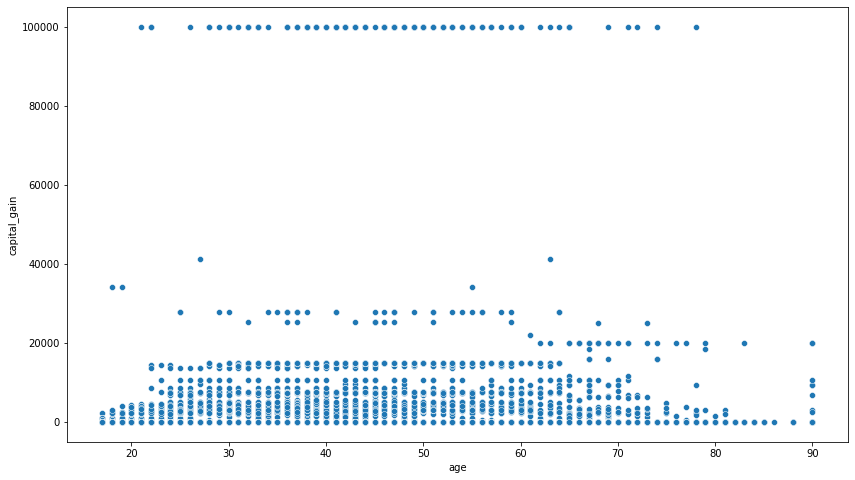

In [7]:
sns.scatterplot(x='age',y='capital_gain',data=df)

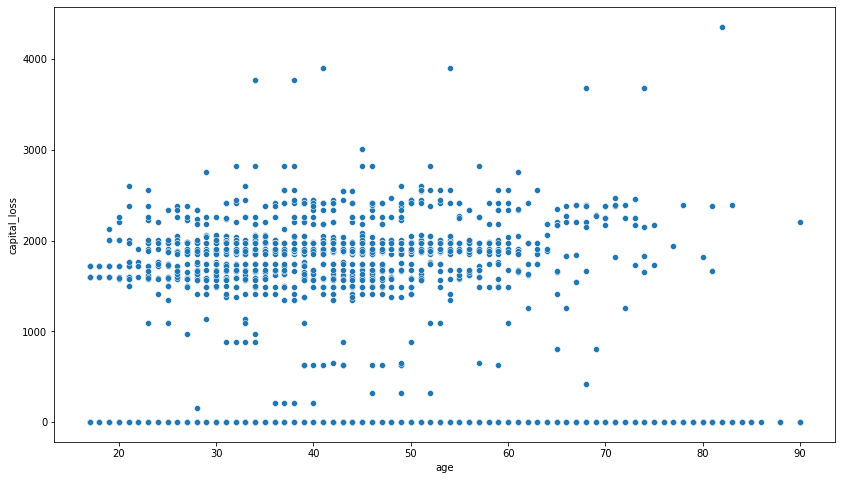

In [8]:
sns.scatterplot(x='age',y='capital_loss',data=df)

**Count Number of Age based on Years of Education Completed**

We can see the number of people with age above 40 either have education for four years or 16 years. This will be important to consider if years of education can influence their income.

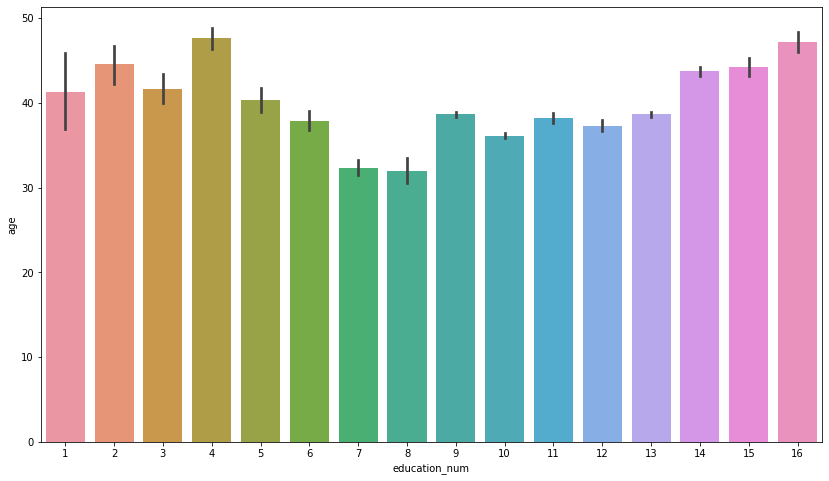

In [9]:
sns.barplot(data=df, x='education_num', y='age')

**Sex**

From the piechart we can see the population of working people are mostly male, with results 67.6%. Meanwhile, by aggregating with age, we can see that the average working people are between 35 and 40, with the average age of females are younger than males.

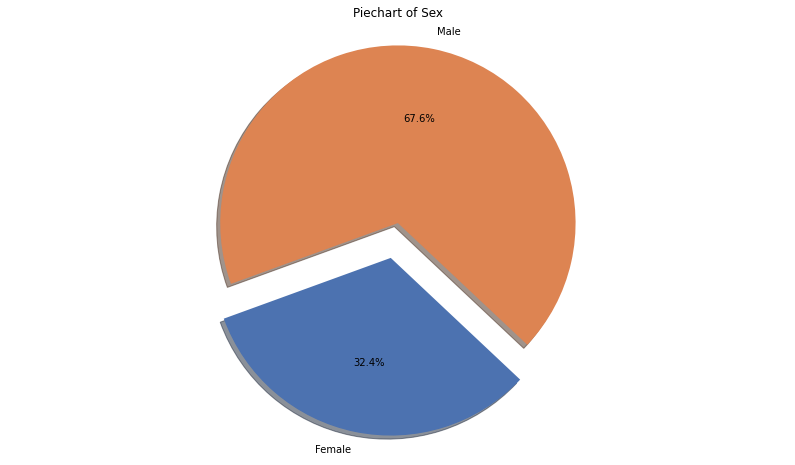

In [10]:
# Creating Plot piechart of Sex
sex_dict = dict(df.sex.value_counts())
labels = 'Female', 'Male'
sizes = [sex_dict["Female"], sex_dict["Male"]]
explode = (0, 0.2)

with sns.color_palette("deep"):
    plt.pie(sizes, explode=explode, labels=labels,
    autopct='%1.1f%%', shadow=True, startangle=200)

# Plot title
plt.axis('equal')
plt.title('Piechart of Sex')
plt.show()

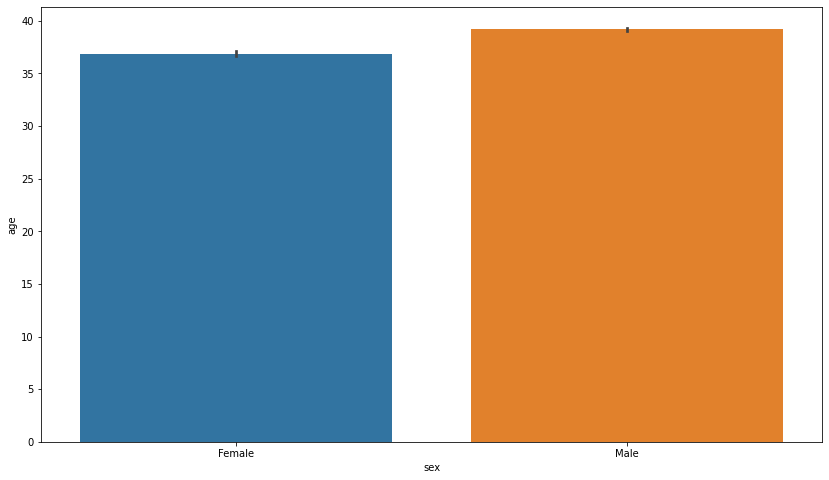

In [11]:
sns.barplot(data=df, x='sex', y='age')

**Marital Status**

We can see that marital status has many labels which later will be merged between `Married-spouse-absent`, `Married-AF-spouse`, and `Married-civ-spouse`. Three of them are essentially still married as in the status. Moreover, the population of `Married-AF-spouse` is only 0.07% and `Married-spouse-absent` is 1.23% which are small and they could be merged with the `Married-civ-spouse` as `Married`.

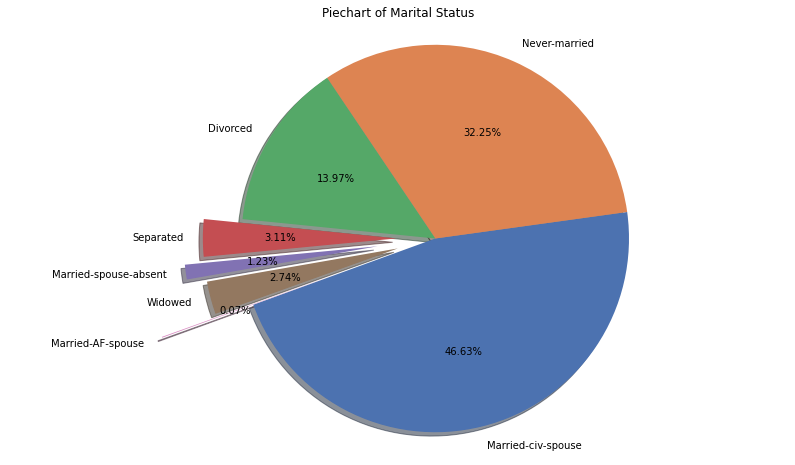

In [12]:
# Creating Plot piechart of Marital Status
marital_status_dict = dict(df.marital_status.value_counts())
labels = 'Married-civ-spouse','Never-married','Divorced','Separated','Married-spouse-absent','Widowed','Married-AF-spouse'
sizes = [marital_status_dict["Married-civ-spouse"], 
         marital_status_dict["Never-married"],
         marital_status_dict['Divorced'], 
         marital_status_dict['Separated'],
         marital_status_dict['Married-spouse-absent'],
         marital_status_dict['Widowed'],
         marital_status_dict['Married-AF-spouse']
         ]

explode = (0, 0, 0, 0.2, 0.3, 0.2, 0.5) 

with sns.color_palette("deep"):
    plt.pie(sizes, explode=explode, labels=labels,
    autopct='%1.2f%%', shadow=True, startangle=200)

# Plot title
plt.axis('equal')
plt.title('Piechart of Marital Status')
plt.show()

**Work hours per week**

We can see that the average of `work hours overall is around no more than 40 hours` based on the histogram of work hours per week and average calculation. However, after aggregating work hours based on native countries, apparently **Thailand** is the highest work hours per week with `47.4 hours`, followed by **France** with `46.3 hours`.

In [13]:
# Average work hours per week
print(f'Average of Work Hours per Week: ', round(df['hours_per_week'].mean(), 2), 'hours.')

Average of Work Hours per Week:  40.93 hours.


Text(0.5, 1.0, 'Histogram of Work Hours per week')

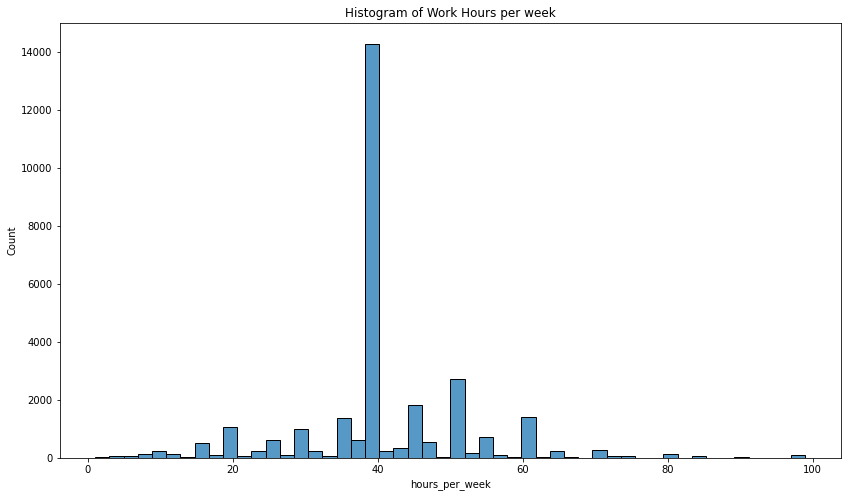

In [14]:
plt.subplot(1,1,1)
sns.histplot(df['hours_per_week'], kde=False, bins=50)
plt.title('Histogram of Work Hours per week')

In [15]:
# Average work hours per week aggregated by native countries 
pd.set_option('display.max_rows', 72)
df.groupby(by=["native_country"]).hours_per_week.agg(["mean"]).sort_values(('mean'), ascending=False)

,mean
native_country,
Thailand,47.411765
France,46.37037
Yugoslavia,44.5625
South,44.464789
Greece,44.241379
Iran,44.071429
Japan,43.966102
England,42.476744
Ireland,42.416667


### **4.2. Correlation Matrix**

#### **4.2.1. Categorical Features**

In [16]:
category_col = df.select_dtypes(include=['object','category']).columns.tolist()
for column in df[category_col]:
    print(f'{column} : {df[column].unique()}')
    print()

workclass : ['Self-emp-not-inc' 'Private' 'Self-emp-inc' 'State-gov' 'Federal-gov'
 'Local-gov' 'Without-pay']

education : ['HS-grad' 'Bachelors' 'Some-college' '9th' '10th' '11th' '12th' '5th-6th'
 '7th-8th' 'Masters' 'Assoc-voc' 'Assoc-acdm' 'Prof-school' 'Doctorate'
 '1st-4th' 'Preschool']

marital_status : ['Married-civ-spouse' 'Never-married' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Widowed' 'Married-AF-spouse']

occupation : ['Sales' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Tech-support'
 'Other-service' 'Prof-specialty' 'Exec-managerial' 'Farming-fishing'
 'Priv-house-serv' 'Protective-serv' 'Transport-moving'
 'Handlers-cleaners' 'Machine-op-inspct']

relationship : ['Wife' 'Husband' 'Own-child' 'Unmarried' 'Not-in-family' 'Other-relative']

race : ['Black' 'White' 'Other' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo']

sex : ['Female' 'Male']

native_country : ['Dominican-Republic' 'United-States' 'Canada' 'South' 'Cuba' 'Mexico'
 'Vietnam' 'Philippines' 'India' 'Ita

**Number of labels: Cardinality**

The number of labels within a categorical variable is known as **cardinality**. A high number of labels within a variable is known as high cardinality. High cardinality may pose some serious problems in the machine learning model, because it makes difficult for the model to identify such patterns and hence the model doesn’t generalise well to examples outside the training set.

In [17]:
# Checking for cardinality in categorical variables
for var in category_col:
    print(f'{var} contains: {len(df[var].unique())} labels.')

workclass contains: 7 labels.
education contains: 16 labels.
marital_status contains: 7 labels.
occupation contains: 14 labels.
relationship contains: 6 labels.
race contains: 5 labels.
sex contains: 2 labels.
native_country contains: 41 labels.
income_bracket contains: 2 labels.


**Encoding the categorical features**

In [18]:
# Creating dataframe for categorical columns
category_col = ['workclass','education','marital_status','occupation','relationship','race','sex','native_country','income_bracket']

df_categorical = df[category_col]
df_categorical.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income_bracket
0,Self-emp-not-inc,HS-grad,Married-civ-spouse,Sales,Wife,Black,Female,Dominican-Republic,>50K
1,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,United-States,<=50K
2,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,United-States,<=50K
3,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,United-States,<=50K
4,Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,United-States,<=50K


In [19]:
# Using LabelEncoder to make categorical to be numerical data
le = LabelEncoder()

df_categorical_encode = df_categorical.copy()
for col in df_categorical_encode.select_dtypes(include='O').columns:
    df_categorical_encode[col]=le.fit_transform(df_categorical_encode[col])
df_categorical_encode.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income_bracket
0,4,11,2,11,5,2,0,5,1
1,2,11,2,11,5,4,0,38,0
2,2,11,2,11,5,4,0,38,0
3,2,11,2,11,5,4,0,38,0
4,2,11,2,11,5,4,0,38,0


**Correlation Matrix for categorical features**

The correlation matrix shows that all features have little and almost no correlation, which will be considered to be proceeded to features selection. However, feature `native_country` will be dropped eariler because of its high cardinality and apparently it does not have any correlation which is really low. Meanwhile `workclass` will be considered and proceeded to the features selection because hypothetically it has the significance with the target `income_bracket`.

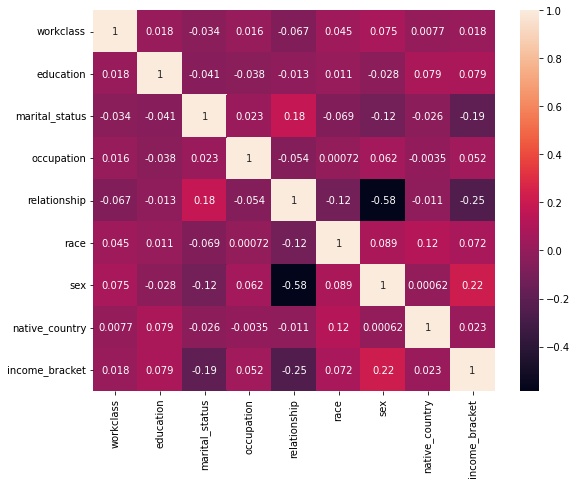

In [20]:
# Plotting Correlation Matrix of Categorical columns and Price
plt.figure(figsize=(9,7))
sns.heatmap(df_categorical_encode.corr(),annot=True)

#### **4.2.2. Numerical Features**

In [21]:
# Using OrdinalEncoder to rank income_bracket
enc = OrdinalEncoder()

income_encode = df.copy()
enc.fit(income_encode[['income_bracket']])
income_encode[['income_bracket']] = enc.transform(income_encode[['income_bracket']])

income_encode = income_encode['income_bracket']
income_encode

0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
30157    0.0
30158    0.0
30159    0.0
30160    0.0
30161    0.0
Name: income_bracket, Length: 30162, dtype: float64

In [22]:
# Creating new dataframe for temperature with price
numerical_cols = ['age','education_num','capital_gain','capital_loss','hours_per_week']
df_num = df[numerical_cols]
df_num.head()

,age,education_num,capital_gain,capital_loss,hours_per_week
0,39,9,0,0,54
1,29,9,0,0,18
2,64,9,0,0,21
3,31,9,0,0,18
4,53,9,0,0,26


In [23]:
# Concatenate data numerical and the labeled target (income_bracket)
df_num = pd.concat([df_num, income_encode], axis=1).sort_index()
df_num

,age,education_num,capital_gain,capital_loss,hours_per_week,income_bracket
0,39,9,0,0,54,1.0
1,29,9,0,0,18,0.0
2,64,9,0,0,21,0.0
3,31,9,0,0,18,0.0
4,53,9,0,0,26,0.0
...,...,...,...,...,...,...
30157,50,10,0,0,70,0.0
30158,21,10,0,0,70,0.0
30159,32,10,0,0,70,0.0
30160,39,9,0,0,70,0.0


**Correlation Matrix for numerical features**

We can see from the correlation matrix that all features have little and almost no correlation, which will be considered to be proceeded to features selection. Those numerical features are `age`, `education_num`, `capital_gain`, `capital_loss` and `hours_per_week`.

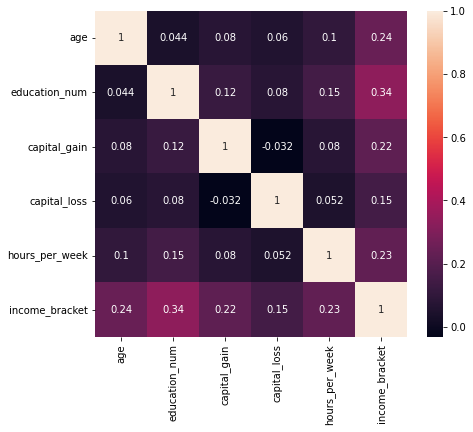

In [24]:
# Plotting Correlation Matrix of Temperature and Price
plt.figure(figsize=(7,6))
sns.heatmap(df_num.corr(),annot=True)

## **5. Data Preprocessing**

### **5.1. Data Inference**

Data inference will take 10 random rows, which we can see the table below. So the rest of data without data inference will be `30152 rows × 14 columns`.

In [25]:
# Creating data inference
df_inf = df.sample(10, random_state=4).sort_index()
df_inf

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
990,49,Private,9th,5,Divorced,Other-service,Not-in-family,Black,Male,0,0,37,United-States,<=50K
2677,18,Private,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,<=50K
7532,32,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,38,United-States,<=50K
13648,40,Private,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,<=50K
17159,67,Self-emp-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>50K
18158,58,Private,Bachelors,13,Widowed,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,<=50K
19765,32,Local-gov,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
19778,28,Private,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,El-Salvador,<=50K
28937,57,Self-emp-inc,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,15024,0,60,United-States,>50K
28963,48,Local-gov,Bachelors,13,Divorced,Prof-specialty,Unmarried,White,Female,0,0,60,United-States,<=50K


In [26]:
# Drop data inference as a new dataframe
df_train_test = df.drop(df_inf.index)
df_train_test

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
1,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
2,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K
3,31,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,53,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,26,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,50,Self-emp-inc,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70,Germany,<=50K
30158,21,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,0,0,70,United-States,<=50K
30159,32,Private,Some-college,10,Separated,Machine-op-inspct,Unmarried,Black,Female,0,0,70,United-States,<=50K
30160,39,Private,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,70,United-States,<=50K


### **5.2. Train and Test Set**

From the train and test set, the features from the data set after handling outliers will drop `income_bracket` because it should be the target instead, and `native_country` because of its high cardinality (41 labels) which will be risky for the encoding and the model later.

In [27]:
# Defining X and y
X = df_train_test.drop(['income_bracket','native_country'],axis=1)
y = pd.DataFrame(df_train_test['income_bracket'])
X

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week
0,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54
1,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18
2,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21
3,31,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18
4,53,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,26
...,...,...,...,...,...,...,...,...,...,...,...,...
30157,50,Self-emp-inc,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70
30158,21,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,0,0,70
30159,32,Private,Some-college,10,Separated,Machine-op-inspct,Unmarried,Black,Female,0,0,70
30160,39,Private,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,70


In [28]:
# Seperating dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=99)

print('Train size : ', X_train.shape)
print('Test size. : ', X_test.shape)

Train size :  (21106, 12)
Test size. :  (9046, 12)


In [29]:
# Calling features variable train set
X_train.sort_index()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week
0,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54
1,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18
4,53,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,26
7,52,Private,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,52
8,23,Private,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,47
...,...,...,...,...,...,...,...,...,...,...,...,...
30154,22,Private,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70
30155,32,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70
30156,37,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70
30157,50,Self-emp-inc,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70


In [30]:
# Calling features variable test set
X_test.sort_index()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week
2,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21
3,31,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18
5,56,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,4
6,28,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Sales,Wife,White,Female,0,0,5
9,59,Self-emp-not-inc,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...
30149,34,Private,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,70
30150,24,Private,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,70
30158,21,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,0,0,70
30160,39,Private,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,70


In [31]:
# Calling target variable train set
y_train.sort_index()

,income_bracket
0,>50K
1,<=50K
4,<=50K
7,>50K
8,<=50K
...,...
30154,>50K
30155,>50K
30156,<=50K
30157,<=50K


In [32]:
# Calling target variable test set
y_test.sort_index()

,income_bracket
2,<=50K
3,<=50K
5,<=50K
6,<=50K
9,>50K
...,...
30149,<=50K
30150,<=50K
30158,<=50K
30160,<=50K


### **5.3. Data Skewness**

Based on the skewness of the data, we can find that both Train set and Test set are `Right Skewed`. This will be useful for outliers later.

In [33]:
# Creating a function to print the skewness
def print_skewness(data):
    print(f'\'{data.name}\' skewness: {data.skew()}')
    # print(f'\'{data.name}\'kurtosis: {data.kurt()}')
    if data.skew() > 0.5:
        print ('Right skewed')
    elif data.skew() < -0.5:
        print( 'Left Skewed')
    else:
        print("Normal Distribution")

In [34]:
# Creating a function to visualize the data
def visualize_data(data):
    print_skewness(data)
    plt.hist(data, bins=65, rwidth=1, density=True)
    plt.xlabel(f'{data.name}')
    plt.ylabel('Probability Density')
    rng = np.arange(data.min(), data.max(), 0.1)
    plt.plot(rng, norm.pdf(rng,data.mean(),data.std()))

    # label the plot
    plt.legend(['Normal PDF(Probability Density Function) ', 'Histogram: Load Weight'])
    plt.axvline(data.mean(), color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(data.median(), color='green', linestyle='dashed', linewidth=2)
    plt.axvline(data.mode()[0], color='red', linestyle='dashed', linewidth=2)
    plt.show()

'age' skewness: 0.5318093442585701
Right skewed


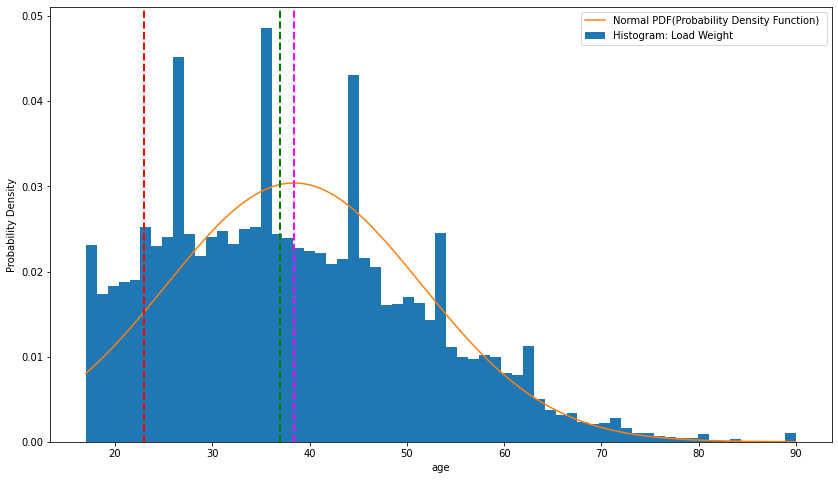

In [35]:
# Visualizing skewed data for X_train
visualize_data(X_train.age)

'age' skewness: 0.5272172737926558
Right skewed


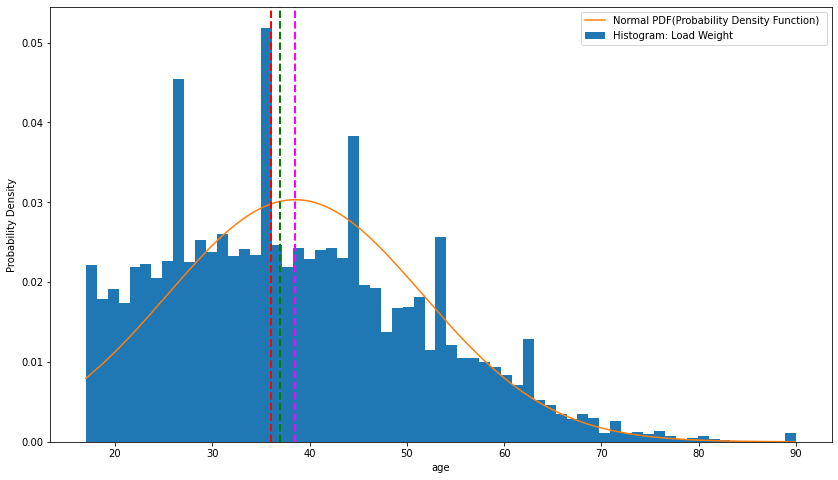

In [36]:
# Visualizing skewed data for X_test
visualize_data(X_test.age)

### **5.4. Outliers**

For outliers, each numerical categories will be determined. We can see that feature `age` is the most suitable to get outlier handling, supported by the data skewness that is previously analyzed, which is right skewed.

The skewness determines which outliers handling method that will be used, in this case is `Tukey's rules` with 1.5 times the interquartile range from the quartiles (1.5IQR).

In [37]:
# Checking the change of Standard Deviation
print('Standard Deviation X_train                 : ', X_train['age'].std())
print('Standard Deviation X_test                  : ', X_test['age'].std())

Standard Deviation X_train                 :  13.124159791644175
Standard Deviation X_test                  :  13.156882680088007


Text(0, 0.5, 'capital_loss')

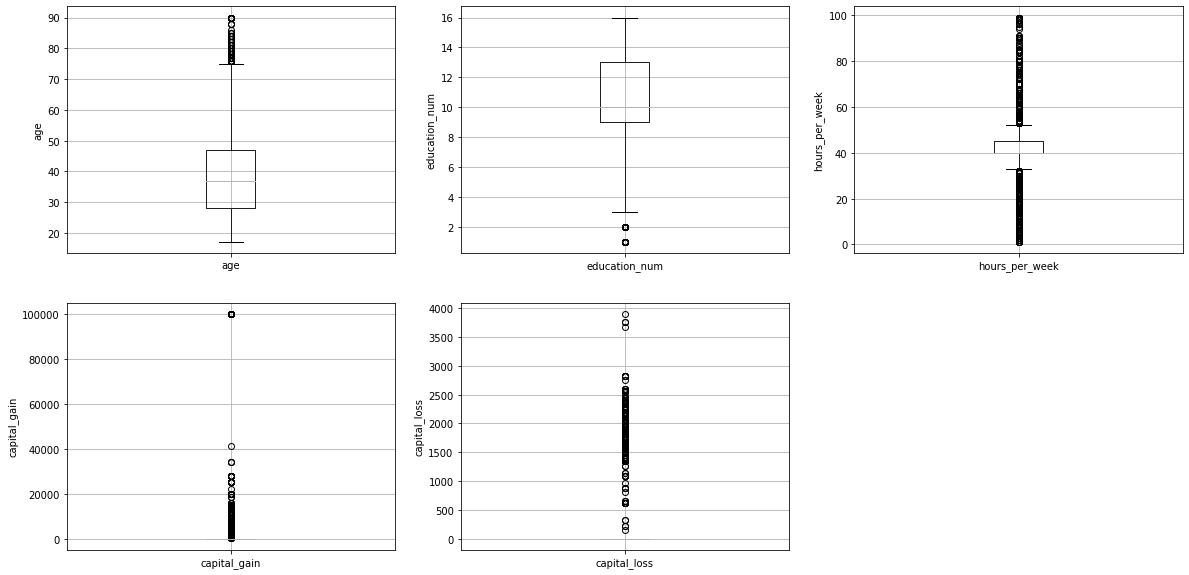

In [38]:
# Draw boxplots to visualize outliers

plt.figure(figsize=(20,10))

plt.subplot(2, 3, 1)
fig1 = X_train.boxplot(column='age')
fig1.set_title('')
fig1.set_ylabel('age')


plt.subplot(2, 3, 2)
fig2 = X_train.boxplot(column='education_num')
fig2.set_title('')
fig2.set_ylabel('education_num')


plt.subplot(2, 3, 3)
fig3 = X_train.boxplot(column='hours_per_week')
fig3.set_title('')
fig3.set_ylabel('hours_per_week')


plt.subplot(2, 3, 4)
fig4 = X_train.boxplot(column='capital_gain')
fig4.set_title('')
fig4.set_ylabel('capital_gain')

plt.subplot(2, 3, 5)
fig4 = X_train.boxplot(column='capital_loss')
fig4.set_title('')
fig4.set_ylabel('capital_loss')

The data that will be taken as outlier is age, because the rest of data do not seem qualified, because of its extremeness. `Age` and `education_num` are the only data with realistic possibility to get outliers handling.

In [39]:
# Calculating Limit for `Age`
Q1 = X_train['age'].quantile(0.25)
Q3 = X_train['age'].quantile(0.75)
IQR = Q3 - Q1

In [40]:
# Calculating Upper Limit Fence
upper_limit = X_train[X_train['age']>(Q3+(1.5*IQR))]

# Calculating Lower Limit Fence
lower_limit = X_train[X_train['age']<(Q1-(1.5*IQR))]

In [41]:
# Checking size before and after removing outliers for Train set
print('Size before removing outliers:',X_train.shape)
X_train_final = X_train[~((X_train['age']>(Q3+(1.5*IQR))))]
print('Size after removing outliers:', X_train_final.shape)

Size before removing outliers: (21106, 12)
Size after removing outliers: (20991, 12)


In [42]:
# Checking size before and after removing outliers for Test set
print('Size before removing outliers:',X_test.shape)
X_test_final = X_test[~((X_test['age']>(Q3+(1.5*IQR))))]
print('Size after removing outliers:', X_test_final.shape)

Size before removing outliers: (9046, 12)
Size after removing outliers: (8992, 12)


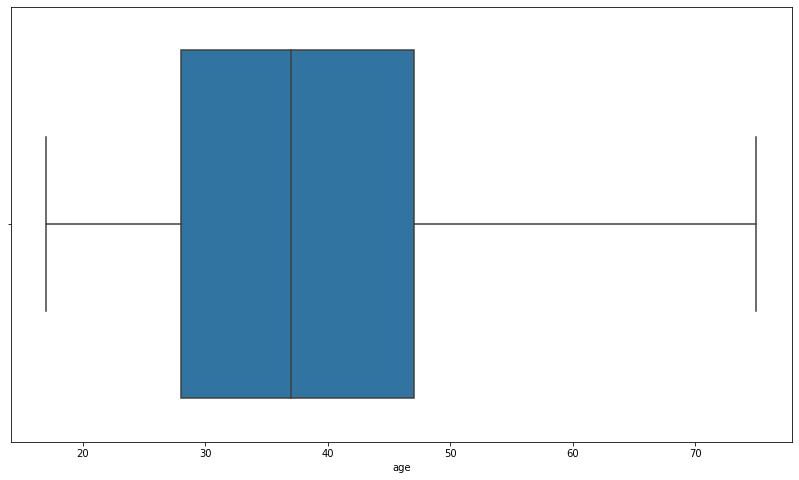

In [43]:
# Checking boxplot after removing outliers
sns.boxplot(x = X_train_final['age'])
plt.show()

We can see the **Q1** should be around age 28 and **Q3** should be around age 47. This is important to understand the range of age and the average age from the train data set. This is proven that `Tukey's Rules` is helpful enough to handle outliers.

We also can see that the number of data after handling outliers is changed from `21106` to `20991` for train set. For test set is from `9046` to `8992`.

In [44]:
# Checking X_train does not have any missing value
X_train_final.isna().sum().sum()

0

**Target Train and Test Set**

First of all, target train and test set should be having the same shape like the features train and test set as in the number of rows.

In [45]:
# Checking size before and after removing outliers for X_train
print('Target Train size before removing outliers:',y_train.shape)
y_train = y_train[~((X_train['age']>(Q3+(1.5*IQR))))]
print('Target Train size after removing outliers:', y_train.shape)

print('Target Test size before removing outliers:',y_test.shape)
y_test = y_test[~((X_test['age']>(Q3+(1.5*IQR))))]
print('Target Test size after removing outliers:', y_test.shape)

Target Train size before removing outliers: (21106, 1)
Target Train size after removing outliers: (20991, 1)
Target Test size before removing outliers: (9046, 1)
Target Test size after removing outliers: (8992, 1)


And then encoding target by using ordinal encoder, because it is important to rank the values `<=50K` as **0** and `>50K` as **1**. However, we have to evaluate what encoding and scaling methods used, which are actually based on the data skewness (Right Skewed):

* **Normal Distribution**: Using Standardization (StandardScaler), centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data.
* **Skewed Distribution** -> Using Normalization (MinMaxScaler), transform features by scaling each feature to a given range between `0` and `1`.

The data is skewed, thus it is important to rank the data instead of just giving the label, particularly for features. However, for target, it can be either ranked or labeled, especially when the unique value is just binary value like `income_bracket`.

In [46]:
# Encoding target train set
y_train.sort_index()

# Using OrdinalEncoder to encode target train and test set
enc = OrdinalEncoder()

income_encode = y_train.copy()
enc.fit(income_encode[['income_bracket']])
income_encode[['income_bracket']] = enc.transform(income_encode[['income_bracket']])
income_encode = income_encode['income_bracket']

y_train_final = pd.DataFrame(income_encode).sort_index()
y_train_final

,income_bracket
0,1.0
1,0.0
4,0.0
7,1.0
8,0.0
...,...
30154,1.0
30155,1.0
30156,0.0
30157,0.0


In [47]:
# Encoding target train set
y_test.sort_index()

# Using OrdinalEncoder to encode target train and test set
enc = OrdinalEncoder()

income_encode = y_test.copy()
enc.fit(income_encode[['income_bracket']])
income_encode[['income_bracket']] = enc.transform(income_encode[['income_bracket']])
income_encode = income_encode['income_bracket']

y_test_final = pd.DataFrame(income_encode).sort_index()
y_test_final

,income_bracket
2,0.0
3,0.0
5,0.0
6,0.0
9,1.0
...,...
30149,0.0
30150,0.0
30158,0.0
30160,0.0


### **5.5. Features Selection**

In [48]:
# Calling X_train_final
X_train_final.sort_index()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week
0,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54
1,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18
4,53,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,26
7,52,Private,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,52
8,23,Private,Some-college,10,Married-civ-spouse,Sales,Wife,White,Female,0,0,47
...,...,...,...,...,...,...,...,...,...,...,...,...
30154,22,Private,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70
30155,32,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70
30156,37,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70
30157,50,Self-emp-inc,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70


In [49]:
X_train_final.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000
mean,38.165118,10.143109,1098.703444,88.104473,40.994474
std,12.753454,2.538396,7460.540363,402.918543,11.863575
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,75.000000,16.000000,99999.000000,3900.000000,99.000000


In [50]:
# Splitting between numerical columns and categorical columns
num_columns = X_train_final.select_dtypes(include=np.number).columns.tolist()
cat_columns = X_train_final.select_dtypes(include=['object']).columns.tolist()

print('Numerical columns  : ', num_columns)
print('Categorical columns  : ', cat_columns)

Numerical columns  :  ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical columns  :  ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex']


In [51]:
# Split Numerical Features
X_train_num = X_train_final[num_columns]
X_test_num = X_test_final[num_columns]

# Split Categorical Features
X_train_cat = X_train_final[cat_columns]
X_test_cat = X_test_final[cat_columns]

#### **5.5.1. Feature Scaling: MinMaxScaler**

As mentioned before, the Feature Scaling will be using Normalization because we can see that data skewness is **Right Skewed**. From here, we can see the ordinality of the scaler instead of just labels.

In [52]:
# Checking numerical dataframe
X_train_num = X_train_num.sort_index()
X_test_num = X_test_num.sort_index()
X_train_num

,age,education_num,capital_gain,capital_loss,hours_per_week
0,39,9,0,0,54
1,29,9,0,0,18
4,53,9,0,0,26
7,52,10,0,0,52
8,23,10,0,0,47
...,...,...,...,...,...
30154,22,7,0,0,70
30155,32,13,0,0,70
30156,37,10,0,0,70
30157,50,10,0,0,70


We can see the feature train set before and after getting scaled, the numbers are changed. Meanwhile after getting scaled, the values are between 0 and 1 ordinally.

In [53]:
# Making feature scaling for numerical columns with Normalizaation - MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train_num)
scaler.fit(X_test_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns, index = X_train_num.index)

X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_num.columns, index = X_test_num.index)

X_test_num_scaled

,age,education_num,capital_gain,capital_loss,hours_per_week
2,0.810345,0.533333,0.0,0.0,0.204082
3,0.241379,0.533333,0.0,0.0,0.173469
5,0.672414,0.533333,0.0,0.0,0.030612
6,0.189655,0.800000,0.0,0.0,0.040816
9,0.724138,0.600000,0.0,0.0,0.806122
...,...,...,...,...,...
30149,0.293103,0.533333,0.0,0.0,0.704082
30150,0.120690,0.533333,0.0,0.0,0.704082
30158,0.068966,0.600000,0.0,0.0,0.704082
30160,0.379310,0.533333,0.0,0.0,0.704082


#### **5.5.2. Feature Encoding: Categorical**

In [54]:
# Making feature encoding for categorical columns
catgeories_col = ['education', 'marital_status', 'occupation', 'relationship','race','sex']
X_train_cat = X_train_cat[catgeories_col].sort_index()
X_test_cat = X_test_cat[catgeories_col].sort_index()
X_train_cat

,education,marital_status,occupation,relationship,race,sex
0,HS-grad,Married-civ-spouse,Sales,Wife,Black,Female
1,HS-grad,Married-civ-spouse,Sales,Wife,White,Female
4,HS-grad,Married-civ-spouse,Sales,Wife,White,Female
7,Some-college,Married-civ-spouse,Sales,Wife,White,Female
8,Some-college,Married-civ-spouse,Sales,Wife,White,Female
...,...,...,...,...,...,...
30154,11th,Married-civ-spouse,Machine-op-inspct,Husband,White,Male
30155,Bachelors,Married-civ-spouse,Machine-op-inspct,Husband,White,Male
30156,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,White,Male
30157,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,White,Male


In [55]:
# Replacing features with high cardinality
X_train_cat["marital_status"] = X_train_cat['marital_status'].replace(['Never-married','Divorced','Seperated','Widowed'], 'Married')
X_test_cat["marital_status"] = X_test_cat['marital_status'].replace(['Never-married','Divorced','Seperated','Widowed'], 'Married')

For encoding the categorical features, we should consider it either LabelEncoder or OneHotEncoder. The difference is that LabelEncoder is not ordinal, and OneHotEncoder is ordinal. Since it is important to consider that each value of each feature is necessary, thus the encoder used is **OneHotEncoder**.

Moreover, **OneHotEncoder** is better used for **input features**, instead LabelEncoder can be used for output target.

In [56]:
# OneHotEncoder will be used for encoding, because there is no need to rank
ohc = OneHotEncoder()

# Encoding OneHotEncoder (ohc) based on the labeled X_train_cat
X_train_cat_encoded = ohc.fit_transform(X_train_cat).toarray()
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, index=X_train_cat.index).sort_index()

X_test_cat_encoded = ohc.transform(X_test_cat).toarray()
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, index = X_test_cat.index).sort_index()

X_train_cat_encoded

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30154,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


#### **5.5.3. Chi-square**

Chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed. The rules for using chi-square are:
* Dataset should be numerical
* No negative value
* Categorical should be encoded before proceeding to use chi-square
* The target must be categorical

First, we have to label all categorircal features using OrdinalEncoder, which both have the same functionality. A bit difference is the idea behind. `OrdinalEncoder` is for converting **features**, while `LabelEncoder` is for converting **target variable**. That's why OrdinalEncoder can fit data that has the shape of (`n_samples`, `n_features`) while LabelEncoder can only fit data that has the shape of (`n_samples,`).

In [57]:
# Encoding categorical columns for chi-square
enc = OrdinalEncoder()
ordinal_cat_train = X_train_cat.copy()
ordinal_cat_test = X_test_cat.copy()

# Encoding ordinal category Train set
ordinal_cat_train = enc.fit_transform(X_train_cat)
ordinal_cat_train = pd.DataFrame(ordinal_cat_train, index=X_train_cat.index, columns=X_train_cat.columns).sort_index()

# Encoding ordinal category Test set
ordinal_cat_test = enc.fit_transform(X_test_cat)
ordinal_cat_test = pd.DataFrame(ordinal_cat_test, index=X_test_cat.index, columns=X_test_cat.columns).sort_index()
ordinal_cat_test

,education,marital_status,occupation,relationship,race,sex
2,11.0,2.0,11.0,5.0,4.0,0.0
3,11.0,2.0,11.0,5.0,4.0,0.0
5,11.0,2.0,11.0,5.0,4.0,0.0
6,9.0,2.0,11.0,5.0,4.0,0.0
9,15.0,2.0,11.0,5.0,4.0,0.0
...,...,...,...,...,...,...
30149,11.0,2.0,5.0,0.0,4.0,1.0
30150,11.0,2.0,5.0,0.0,2.0,1.0
30158,15.0,0.0,6.0,3.0,4.0,0.0
30160,11.0,0.0,6.0,1.0,2.0,0.0


In [58]:
# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(ordinal_cat_train, y_train)

chi = pd.Series(fit.scores_)
chi.index = ordinal_cat_train.columns
chi.sort_values(ascending=False)

occupation        9.499030
marital_status    1.181223
race              0.999834
education         0.597212
relationship      0.564723
sex               0.100204
dtype: float64

In [59]:
# k = 4 tells four top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(ordinal_cat_test, y_test)

chi = pd.Series(fit.scores_)
chi.index = ordinal_cat_test.columns
chi.sort_values(ascending=False)

marital_status    3.715097
relationship      1.123414
education         0.794635
occupation        0.445020
sex               0.204054
race              0.065871
dtype: float64

Based on chi-squared analysis above, we can see that `marital_status`, `occupation`, and `education` are three top statistically significant features. This is also the same result with **Correlation Matrixes** (with some notes that the correlation analysis, there is no train and test set). 

### **5.6. Final Result from Data Preprocessing**

These are the description of comparison based on features selection, from **EDA**, **Correlation Matrices**, and **Chi-square** analysis, which these features will be used for logistic regression and SVM model. Chi-square will show top 5 features selected, especially categorical features, which will be supported by correlation matrices. Meanwhile, all numerical features are used in the model.

**Comparison Results**

Features Selection | Description
---|---
`sex` | stronger correlation, weaker chi-square
`relationship` | stronger correlation, moderate chi-square
`marital_status` | stonger correlation, stronger chi-square
`occupation` | weaker correlation, stronger chi-square
`education` | weaker correlation, moderate chi-square
`education_num` | stronger correlation
`capital_gain` | moderate correlation
`capital_loss` | weaker correlation
`hours_per_week` | stronger correlation
`age` | stonger correlation

Features that are dropped are `native_country` because of its high cardinality, and `race` which only matters in train set, however race is relatively weaker in correlation and chi-square.

**Conctenate all scaled and encoded dataframe**

In [60]:
# Making feature encoding for categorical columns
catgeories_col = ['education', 'marital_status', 'occupation', 'relationship','sex']
X_train_cat = X_train_cat[catgeories_col].sort_index()
X_test_cat = X_test_cat[catgeories_col].sort_index()
X_train_cat

# Replacing features with high cardinality
X_train_cat["marital_status"] = X_train_cat['marital_status'].replace(['Never-married','Divorced','Seperated','Widowed'], 'Married')
X_test_cat["marital_status"] = X_test_cat['marital_status'].replace(['Never-married','Divorced','Seperated','Widowed'], 'Married')

# OneHotEncoder will be used for encoding, because there is no need to rank
ohc = OneHotEncoder()

# Encoding OneHotEncoder (ohc) based on the labeled X_train_cat
X_train_cat_encoded = ohc.fit_transform(X_train_cat).toarray()
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, index=X_train_cat.index).sort_index()

# Encoding OneHotEncoder (ohc) based on the labeled X_test_cat
X_test_cat_encoded = ohc.transform(X_test_cat).toarray()
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, index = X_test_cat.index).sort_index()

In [61]:
# Concatenate dataframe X_train_final
X_train_final = pd.concat([X_train_cat_encoded, X_train_num_scaled], axis=1)
X_train_final = X_train_final.sort_index()
X_train_final

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,age,education_num,capital_gain,capital_loss,hours_per_week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.379310,0.533333,0.0,0.0,0.540816
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.206897,0.533333,0.0,0.0,0.173469
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.620690,0.533333,0.0,0.0,0.255102
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.603448,0.600000,0.0,0.0,0.520408
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.103448,0.600000,0.0,0.0,0.469388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30154,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.086207,0.400000,0.0,0.0,0.704082
30155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.258621,0.800000,0.0,0.0,0.704082
30156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.344828,0.600000,0.0,0.0,0.704082
30157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.568966,0.600000,0.0,0.0,0.704082


In [62]:
# Concatenate dataframe X_test_final
X_test_final = pd.concat([X_test_cat_encoded, X_test_num_scaled], axis=1)
X_test_final = X_test_final.sort_index()
X_test_final

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,age,education_num,capital_gain,capital_loss,hours_per_week
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.810345,0.533333,0.0,0.0,0.204082
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.241379,0.533333,0.0,0.0,0.173469
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.672414,0.533333,0.0,0.0,0.030612
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.189655,0.800000,0.0,0.0,0.040816
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.724138,0.600000,0.0,0.0,0.806122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.293103,0.533333,0.0,0.0,0.704082
30150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.120690,0.533333,0.0,0.0,0.704082
30158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.068966,0.600000,0.0,0.0,0.704082
30160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.379310,0.533333,0.0,0.0,0.704082


## **6. Model Definition**

### **6.1. Logistic Regression**

Logistic Regression model can be classified into three groups based on the target variable categories. These three groups are described below:-

1. **Binary Logistic Regression** \
The target variable has two possible categories. The common examples of categories are yes or no, good or bad, true or false, spam or no spam and pass or fail.

2. Multinomial Logistic Regression \
The target variable has three or more categories which are not in any particular order. So, there are three or more nominal categories. The examples include the type of categories of fruits - apple, mango, orange and banana.

3. Ordinal Logistic Regression \
The target variable has three or more ordinal categories. So, there is intrinsic order involved with the categories. For example, the student performance can be categorized as poor, average, good and excellent.

However, in regression, **it has more errors in predicting especially when the target is not numerical**. This is one of the disadventages from logistic regression.

Since we can see that the target (`income_bracket`) only has two unique values, then the regression will be binary logistic regression.

In [63]:
# Defining Logistic Regression
log_model = LogisticRegression(solver="lbfgs", C=1)
log_model.fit(X_train_final,y_train_final)

LogisticRegression(C=1)

### **6.2. Support Vector Machine (SVM)**

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. SVMs are usually used to solved **Binary Classification** problems.

There are some benefits from using SVMs:
* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the **decision function** (called **support vectors**), so it is also memory efficient.
* **Versatile**: different **Kernel functions** can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels. Those kernels are `linear`, `poly`, `rbf` (default), `sigmoid`, `precomputed`.

The disadvantages of support vector machines include:
* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide `probability estimates`, the model evaluation should be calculated by `cross-validation`.

In [64]:
# SVM Classifier model
svm_clf = SVC(C=1, kernel='rbf', gamma='scale')
svm_clf.fit(X_train_final,y_train_final)

SVC(C=1)

## **7. Model Training**

### **7.1. Logistic Regression**

In [65]:
# Predicting target (y_train) with linear regression
y_pred_train = log_model.predict(X_train_final)
y_pred_test = log_model.predict(X_test_final)

# Creating target prediction dataframe
y_pred_train_final = pd.DataFrame(data = y_pred_train, columns = ["Prediction Train"])
y_pred_test_final = pd.DataFrame(data = y_pred_test, columns = ["Prediction Test"])

In [66]:
# Encoding LabelEncoder
le = LabelEncoder()

# Encoding label target predicted Train set
y_pred_train_final = le.fit_transform(y_pred_train_final)
y_pred_train_final = pd.DataFrame(data = y_pred_train_final, columns = ["Prediction Train"])

# Encoding label target predicted Test set
y_pred_test_final = le.fit_transform(y_pred_test_final)
y_pred_test_final = pd.DataFrame(data = y_pred_test_final, columns = ["Prediction Test"])

In [67]:
y_pred_train_final.value_counts()

Prediction Train
0                   16730
1                    4261
dtype: int64

In [68]:
y_pred_test_final.value_counts()

Prediction Test
0                  7237
1                  1755
dtype: int64

### **7.2. Support Vector Machine (SVM)**

In [69]:
# Predicting target (y_train) with SVM
y_pred_train_svm = svm_clf.predict(X_train_final)
y_pred_test_svm = svm_clf.predict(X_test_final)

# Creating target model to be dataframe
y_pred_train_svm_final = pd.DataFrame(data = y_pred_train_svm, columns = ["Prediction Train"])
y_pred_test_svm_final = pd.DataFrame(data = y_pred_test_svm, columns = ["Prediction Train"])

In [70]:
# Encoding LabelEncoder
le = LabelEncoder()

# Encoding label target predicted Train set
y_pred_train_svm_final = le.fit_transform(y_pred_train_svm_final)
y_pred_train_svm_final = pd.DataFrame(data = y_pred_train_svm, columns = ["Prediction Train"])

# Encoding label target predicted Test set
y_pred_test_svm_final = le.fit_transform(y_pred_test_svm_final)
y_pred_test_svm_final = pd.DataFrame(data = y_pred_test_svm, columns = ["Prediction Train"])

In [71]:
y_pred_train_svm_final.value_counts()

Prediction Train
0.0                 17018
1.0                  3973
dtype: int64

In [72]:
y_pred_test_svm_final.value_counts()

Prediction Train
0.0                 7364
1.0                 1628
dtype: int64

## **8. Model Evaluation**

### **8.1. Logistic Regression**

Based on the accuracy score of train and test set, we can see that the predicted classification from logistic regression model is **fairly accutate**, with results almost the same, `84%`. This model is not over-fitting, but it is still accurate.

In [73]:
print('accuracy score train : ', round(accuracy_score(y_train_final, y_pred_train_final)*100,2),'%')
print('accuracy score test  : ', round(accuracy_score(y_test_final, y_pred_test_final)*100,2), '%')

accuracy score train :  84.56 %
accuracy score test  :  83.82 %


In [74]:
log_model.classes_

array([0., 1.])

#### **8.1.1. Confusion Matrix**

Confusion Matrix is a specific table layout that allows visualization of the performance of an algorithm. From the train and test set below, we can see that **top-left represents true positive** and **bottom-right represent true negative**. The distribution of true positive and true negative are proportionally suitable with the accuracy mentioned above.

Meanwhile, **top-right represents false-positive** and **bottom-left means false-negative**, which means those are basically errors. This is why confusion matrix is known as an error matrix.

**Confusion Matrix Train Set**

- True-Positive  (`0 predicted`, `0 true`) : 14,629
- True-Negative  (`1 predicted`, `1 true`) : 3,120
- False-Positive (`0 predicted`, `1 true`) : 2,101
- False-Negative (`1 predicted`, `0 true`) : 1,141

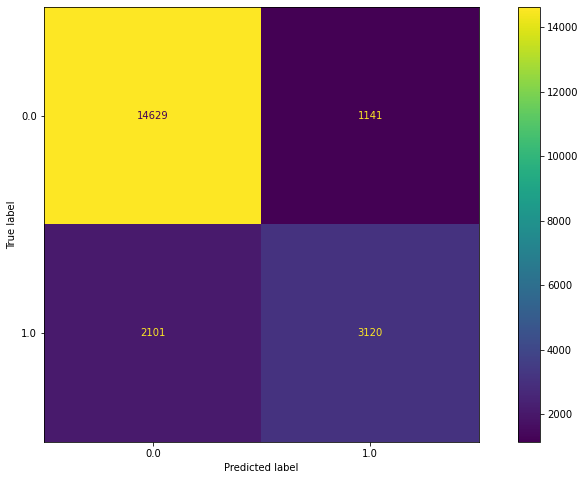

In [75]:
# Creating confusion matrix for train set
cm = confusion_matrix(y_train_final, y_pred_train_final, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

**Confusion Matrix Test set**

- True-Positive  (`0 predicted`, `0 true`) : 6,259
- True-Negative  (`1 predicted`, `1 true`) : 1,278
- False-Positive (`0 predicted`, `1 true`) : 978
- False-Negative (`1 predicted`, `0 true`) : 477

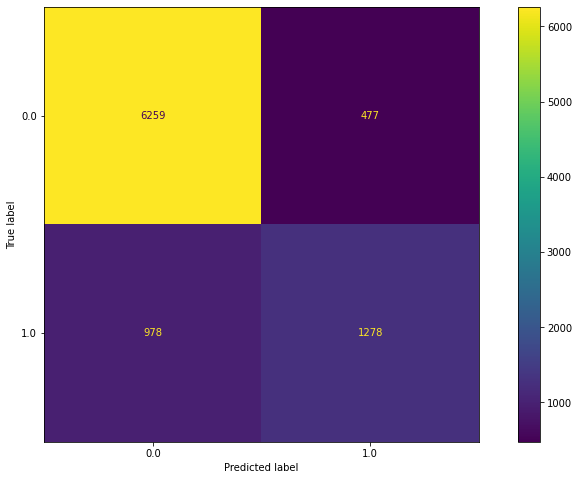

In [76]:
# Creating confusion matrix for train set
cm = confusion_matrix(y_test_final, y_pred_test_final, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

#### **8.1.2. Classification Report**

`F1-score` is one of the most important evaluation metrics in machine learning. It elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall. An F1 score is considered `perfect` when it is 1 , while the model is a `total failure` when it is 0.

**Train Set**

In [77]:
# Determining classification report for train set
print(classification_report(y_train_final,y_pred_train_final))

# Get Precision Score and Recall Score - Train Set
print('Precision (Train Set) : ', precision_score(y_train_final, y_pred_train_final))
print('Recall (Train Set)    : ', recall_score(y_train_final, y_pred_train_final))

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90     15770
         1.0       0.73      0.60      0.66      5221

    accuracy                           0.85     20991
   macro avg       0.80      0.76      0.78     20991
weighted avg       0.84      0.85      0.84     20991

Precision (Train Set) :  0.7322224829852148
Recall (Train Set)    :  0.5975866692204559


**Test Set**

In [78]:
# Determining classification report for test set
print(classification_report(y_test_final, y_pred_test_final))

# Get Precision Score and Recall Score - Test Set
print('Precision (Test Set) : ', precision_score(y_test_final, y_pred_test_final))
print('Recall (Test Set)    : ', recall_score(y_test_final, y_pred_test_final))

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90      6736
         1.0       0.73      0.57      0.64      2256

    accuracy                           0.84      8992
   macro avg       0.80      0.75      0.77      8992
weighted avg       0.83      0.84      0.83      8992

Precision (Test Set) :  0.7282051282051282
Recall (Test Set)    :  0.5664893617021277


#### **8.1.3. AUC ROC (Area Under the ROC Curve)**

The ROC curve is the plot between sensitivity and "1-specificity". "1- specificity" is also known as **False Positive Rate (FPR)** and sensitivity is also known as **True Positive Rate (TPR)**.

Following are a few thumb rules:
- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

These rates are basically the same concept like confusion matrix. In summary, we can see that both train set and test set have **a fair score** of True Positive Rate (TPR), and this might simply be the model is moderate, neither over-fitting nor under-fitting.

AUC Score :  0.7626170505265248
False Positive Rate(FPR)    0.316461
True Positive Rate(TPR)     0.758593
dtype: float64


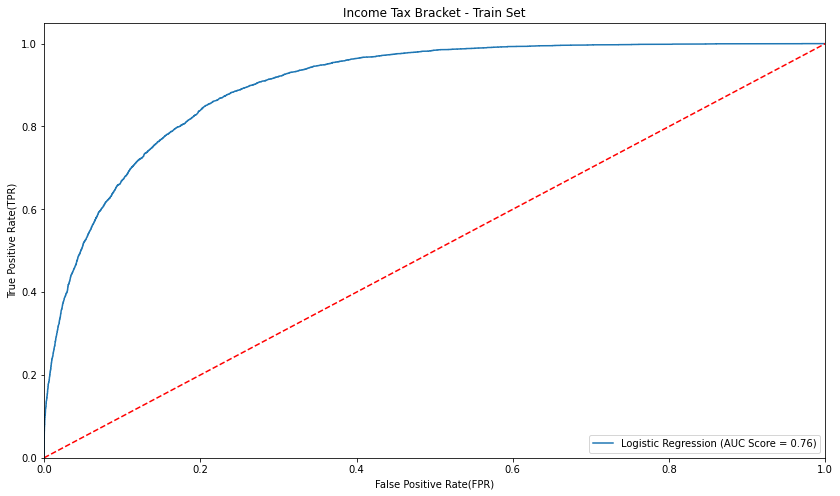

In [79]:
# Generating AUC-ROC curve Train set
log_train_roc_auc = roc_auc_score(y_train_final, log_model.predict(X_train_final))
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_final, log_model.predict_proba(X_train_final)[:,1])
print('AUC Score : ', log_train_roc_auc)
print(pd.DataFrame({'False Positive Rate(FPR)': fpr_train, 'True Positive Rate(TPR)': tpr_train}).mean())

# Plot ROC Curve Train set
plt.figure()
plt.plot(fpr_train, tpr_train, label='Logistic Regression (AUC Score = %0.2f)' % log_train_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Income Tax Bracket - Train Set')
plt.legend(loc="lower right")
plt.show()

AUC Score :  0.7478379112548642
FPR    0.278278
TPR    0.736816
dtype: float64


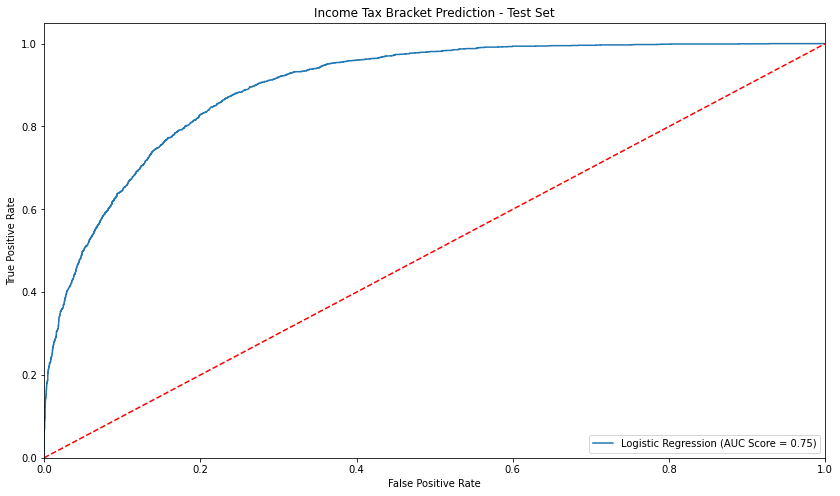

In [80]:
# Generating AUC-ROC curve Test set
log_test_roc_auc = roc_auc_score(y_test_final, log_model.predict(X_test_final))
fpr_test, tpr_test, thresholds_svc = roc_curve(y_test_final, log_model.predict_proba(X_test_final)[:,1])
print('AUC Score : ', log_test_roc_auc)
print(pd.DataFrame({'FPR': fpr_test, 'TPR': tpr_test}).mean())

# Plot ROC Curve Test set
plt.figure()
plt.plot(fpr_test, tpr_test, label='Logistic Regression (AUC Score = %0.2f)' % log_test_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Income Tax Bracket Prediction - Test Set')
plt.legend(loc="lower right")
plt.show()

### **8.2. Support Vector Machine (SVM)**

From evaluating SVM, we can see that SVM has totally a different concept with regression. SVM is the classification machine learning, meanwhile regression is probability estimator. This is why the result of accuracy of SVM is **biased** with 100% accuracy, which is over-fitting.

Accuracy, confusion matrix, and classification report cannot evaluate the model. On the other hand, `cross-validation` is possible to evaluate the model, although cross-validation itself is not an evaluation method.

In [81]:
# Determining the accuracy of SVM model
print('accuracy score train : ', round(accuracy_score(y_pred_train_svm, y_pred_train_svm_final)*100,2),'%')
print('accuracy score test  : ', round(accuracy_score(y_pred_test_svm, y_pred_test_svm_final)*100,2), '%')

accuracy score train :  100.0 %
accuracy score test  :  100.0 %


In [82]:
svm_clf.classes_

array([0., 1.])

#### **8.2.1. Confusion Matrix**

Confusion matrix for SVM can be seen that the seperation and classification between `<=50K` and `>50K` are **obvious**.

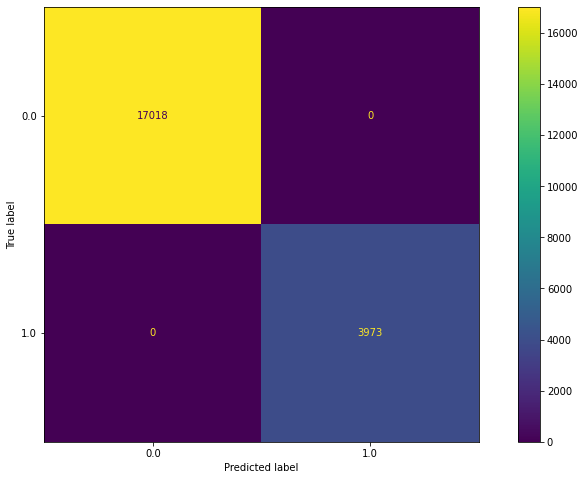

In [83]:
# Creating confusion matrix for train set
cm = confusion_matrix(y_pred_train_svm, y_pred_train_svm_final, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=log_model.classes_)

disp.plot()
plt.show()

#### **8.2.2. Classification Report**

We can see the classification report results are 100% correct. It is because of the classification report based on probability, whereas SVM is clearly for solving binary classification problem, which the result is either `0` or `1`, and no between them just like probability problem solving.

Further determination for test set would not be done since the result will be clearly 100%.

In [84]:
# Determining classification report for train set
print(classification_report(y_pred_train_svm, y_pred_train_svm_final))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17018
         1.0       1.00      1.00      1.00      3973

    accuracy                           1.00     20991
   macro avg       1.00      1.00      1.00     20991
weighted avg       1.00      1.00      1.00     20991



In [85]:
# Get Precision Score and Recall Score - Train Set
print('Precision (Train Set) : ', precision_score(y_pred_train_svm, y_pred_train_svm_final))
print('Recall (Train Set)    : ', recall_score(y_pred_train_svm, y_pred_train_svm_final))

Precision (Train Set) :  1.0
Recall (Train Set)    :  1.0


#### **8.2.3. Cross-Validation**

We can see that the results of `cross-validation` are still high, which might be over-fitting. The over-fitting could be influenced by the choosing Kernel functions (gamma) and regularization parameters (C) that are either too small or big.

However, this is the problem from SVM, where the smaller C and gamma will make the model take more time to process. Thus, the usage of SVM should be considered based on its **model processing time**.

In [86]:
# Calculating cross-validation with k=5
cv_train = cross_val_score(svm_clf, X_train_final, y_pred_train_svm, cv=5)
cv_test = cross_val_score(svm_clf, X_test_final, y_pred_test_svm, cv=5)

print("Cross Validation of Train set: %0.4f accuracy with a standard deviation of %0.4f" % (cv_train.mean(), cv_train.std()))
print("Cross Validation of Test set : %0.4f accuracy with a standard deviation of %0.4f" % (cv_test.mean(), cv_test.std()))

Cross Validation of Train set: 0.9884 accuracy with a standard deviation of 0.0039
Cross Validation of Test set : 0.9865 accuracy with a standard deviation of 0.0024


## **9. Model Inference**

Model inference is raw data that is input to the model. Since there are only 10 data, handling outliers could be skipped. From here, we can compare and observe if the actual data of `income_bracket` is correct with the `predicted classification`.

### **9.1. Save and Load Model**

In [87]:
# Save the model files
with open('log_model.pkl', 'wb') as file_1:
  joblib.dump(log_model, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  joblib.dump(scaler, file_2)

with open('model_onehotencoder.pkl', 'wb') as file_3:
  joblib.dump(ohc, file_3)

with open('model_ordinalencoder.pkl', 'wb') as file_4:
  joblib.dump(enc, file_4)

with open('model_labelencoder.pkl', 'wb') as file_5:
  joblib.dump(le, file_5)

with open('num_columns.txt', 'w') as file_6:
  json.dump(num_columns, file_6)

with open('cat_columns.txt', 'w') as file_7:
  json.dump(cat_columns, file_7)

In [88]:
# Load all model files
with open('log_model.pkl', 'rb') as file_1:
  log_model = joblib.load(file_1)

with open('model_scaler.pkl', 'rb') as file_2:
  model_scaler = joblib.load(file_2)

with open('model_onehotencoder.pkl', 'rb') as file_3:
  model_onehotencoder = joblib.load(file_3)

with open('model_ordinalencoder.pkl', 'rb') as file_4:
  model_ordinalencoder = joblib.load(file_4)

with open('model_labelencoder.pkl', 'rb') as file_5:
  model_labelencoder = joblib.load(file_5)

with open('num_columns.txt', 'r') as file_6:
  num_columns = json.load(file_6)

with open('cat_columns.txt', 'r') as file_7:
  cat_columns = json.load(file_7)

### **9.2. Features Selection**

In [89]:
# Calling numerical columns from the loaded model
num_columns

['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

In [90]:
# Calling categorical columns from the loaded model
cat_columns

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex']

In [91]:
# Split between Numerical Columns and Categorical Columns of data inference
df_inf_num = df_inf[num_columns]
df_inf_cat = df_inf[cat_columns]
df_inf_num

,age,education_num,capital_gain,capital_loss,hours_per_week
990,49,5,0,0,37
2677,18,8,0,0,15
7532,32,9,0,0,38
13648,40,9,0,0,40
17159,67,9,0,0,40
18158,58,13,0,0,40
19765,32,10,0,0,40
19778,28,10,0,0,40
28937,57,15,15024,0,60
28963,48,13,0,0,60


In [92]:
# Feature Scaling for data inference
df_inf_num_scaled = model_scaler.transform(df_inf_num)
df_inf_num_scaled = pd.DataFrame(df_inf_num_scaled, columns = df_inf_num.columns, index = df_inf_num.index)
df_inf_num_scaled

,age,education_num,capital_gain,capital_loss,hours_per_week
990,0.551724,0.266667,0.000000,0.0,0.367347
2677,0.017241,0.466667,0.000000,0.0,0.142857
7532,0.258621,0.533333,0.000000,0.0,0.377551
13648,0.396552,0.533333,0.000000,0.0,0.397959
17159,0.862069,0.533333,0.000000,0.0,0.397959
18158,0.706897,0.800000,0.000000,0.0,0.397959
19765,0.258621,0.600000,0.000000,0.0,0.397959
19778,0.189655,0.600000,0.000000,0.0,0.397959
28937,0.689655,0.933333,0.150242,0.0,0.602041
28963,0.534483,0.800000,0.000000,0.0,0.602041


In [93]:
# Feature Encoding for data inference
df_inf_cat = df_inf_cat.drop(['workclass','race'], axis=1)

In [94]:
# Replacing features with high cardinality
df_inf_cat["marital_status"] = df_inf_cat['marital_status'].replace(['Never-married','Divorced','Seperated','Widowed'], 'Married')
df_inf_cat["marital_status"] = df_inf_cat['marital_status'].replace(['Never-married','Divorced','Seperated','Widowed'], 'Married')

# Encoding OneHotEncoder (ohc) based on the encoded X_train_cat
df_inf_cat_encoded = model_onehotencoder.transform(df_inf_cat).toarray()
df_inf_cat_encoded = pd.DataFrame(df_inf_cat_encoded, index=df_inf_cat.index).sort_index()
df_inf_cat_encoded

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
19765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
28963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### **9.3. Concatenate Scaled and Encoded Features**

In [95]:
# Concatenate Numerical Columns and Categorical Columns
df_inf_final = pd.concat([df_inf_cat_encoded, df_inf_num_scaled], axis=1)
df_inf_final = df_inf_final.sort_index()
df_inf_final

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,age,education_num,capital_gain,capital_loss,hours_per_week
990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.551724,0.266667,0.000000,0.0,0.367347
2677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.017241,0.466667,0.000000,0.0,0.142857
7532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.258621,0.533333,0.000000,0.0,0.377551
13648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.396552,0.533333,0.000000,0.0,0.397959
17159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.862069,0.533333,0.000000,0.0,0.397959
18158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.706897,0.800000,0.000000,0.0,0.397959
19765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.258621,0.600000,0.000000,0.0,0.397959
19778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.189655,0.600000,0.000000,0.0,0.397959
28937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.689655,0.933333,0.150242,0.0,0.602041
28963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.534483,0.800000,0.000000,0.0,0.602041


### **9.4. Model Training Inference**

In modeling inference, we will get the binary results (0 and 1) which means:
- `0` for income tax payment `<=50K`
- `1` for income tax payment `>50K`

We can see that there are 2 results with `>50K`, and 8 results with `<=50K`.

In [96]:
# Predict using Linear regression
y_pred_inf = log_model.predict(df_inf_final)

# Create DataFrame
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['Predicted Classification (Inference)'],index=df_inf_final.index)
y_pred_inf_df

,Predicted Classification (Inference)
990,0.0
2677,0.0
7532,0.0
13648,0.0
17159,1.0
18158,0.0
19765,0.0
19778,0.0
28937,1.0
28963,0.0


In [97]:
# Comparing the real income bracket and predicted classification
model_inf = pd.concat([df_inf['income_bracket'], y_pred_inf_df['Predicted Classification (Inference)']], axis=1).sort_index()
model_inf

,income_bracket,Predicted Classification (Inference)
990,<=50K,0.0
2677,<=50K,0.0
7532,<=50K,0.0
13648,<=50K,0.0
17159,>50K,1.0
18158,<=50K,0.0
19765,<=50K,0.0
19778,<=50K,0.0
28937,>50K,1.0
28963,<=50K,0.0


### **9.5. Summary from Model Inference**

Since there are just 10 data inference taken, we can see clearly that index number `17159` and `28937` have value `1`, which means these two people are expected to get the income tax bracket more than 50,000 (`>50K`). Moreover, **the prediction is apparently correct** with what the actual data.

* We can see that index number `17159` must pay their tax more than 50,000 because of their `occupation` as `Executive Managerial` which **probably** has a high influence to the amount of tax they should pay. Meanwhile for index `28937`, they have `occupation` as `Profession Speciality` and `capital_gain` with `15024` which have probability that make them should pay tax more than 50,000.

Finally, we can see that model is **accurate enough to predict**. On the other hand, it should be noted that this model inference is `just 10 data`, which could be **not enough to represent the accuracy**. We can see the accuracy of the regression model from train and test set instead.

## **10. Conclusion**

In classification problems, there are two types of algorithms which are dependent on the kind of output created:

* **Class output**: Algorithms like SVM creates a class output. For instance, in a binary classification problem, the outputs will be either `0` or `1`.
* **Probability output**: Algorithms like Logistic Regression gives `probability outputs`. Converting probability outputs to class output is just a matter of creating a threshold probability.

### **Logistic Regression**

The Logistic Regression model requires several key assumptions. These are as follows:
* Logistic Regression model **requires the dependent variable** to be binary, multinomial or ordinal values in nature.
* It requires **the features observed to be independent of each other**.
* It requires **little or no correlation among the features** (independent variables).
* The success of Logistic Regression model depends on **the sample sizes**. The higher the sample size is, the more accurate the model will be.

*What does it mean of coefficient in logistic regression?*
> It means the same concept like in every regression concept. **The coefficient is an estimation for a corresponding feature** that can influence the strength of the features (independent variables) in affecting the target or the dependent variable. For example, the dependent variable (target) is expected to increase if the coefficient is positive or decrease if the coefficient is negative.

In this case, we can see that there are 

In [98]:
# Coefficient Logistic Regression
log_model.coef_

array([[-2.83728314e-01, -4.50602313e-01, -1.79763195e-02,
         3.90756379e-02, -6.54685221e-01, -8.84607863e-01,
        -4.85766798e-01,  4.61477436e-02,  2.09250590e-01,
         4.90857308e-01,  8.04043414e-01, -2.50441723e-02,
         5.76578878e-01, -8.28057549e-01,  1.12217425e+00,
         1.47089159e-01, -9.54875830e-01,  1.21211316e+00,
         9.58112728e-01, -6.04064960e-01, -8.06536665e-01,
         1.81971287e-01, -1.41857195e-01,  1.28024598e-01,
         9.17813931e-01, -9.97771660e-01, -5.75411204e-01,
        -9.40117854e-02, -7.41251574e-01, -1.47462958e+00,
         6.79173372e-01,  5.90319568e-01,  4.09505801e-01,
         9.14463699e-01,  8.40917006e-03,  6.60719236e-02,
         2.12945405e-01, -7.14512749e-01, -1.16700630e+00,
         1.53182803e-01,  1.25406734e+00, -4.97673350e-01,
         3.02421780e-01,  1.70438664e+00,  2.31768058e+00,
         1.51004800e+01,  2.21314013e+00,  2.89762088e+00]])

As the function of regression:
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \cdots
$$
Where:
- $a_0$ is intercept (constant)
- $a_n$ is the n-value of the data
- $x_n$ is coefficient estimate of n-value

> With the logistic regression model, `intercept` is basically **the constant value of the model**, we can see that incercept represents the mean value of the response variable when all of the predictor variables in the model are equal to zero. In this case, `income tax bracket` has `-5.70` constant value as its $a_0$ and it could be changed depending on the features included in the logistic regression model.

In [99]:
# Intercept Logistic Regression
log_model.intercept_

array([-5.69814999])

### **Support Vector Machine (SVM)**

We can conclude that SVM is basically **a Classification model** to seperate different groups or classes with a particular plane (called hyperplane). What we have to understand is that `type of kernels`, `kernel coefficient` (gamma), and `regulation parameters` (C) are important to determine the result of classification and its accuracy.

As in our case `income tax bracket` classification, we can see that the accuracy is 100%, because the seperation between binary targets (`<=50K` and `>50K`) are obvious. The classification is either `0` or `1`, that is why the accuracy will be wither `0` or `100%`. This is because of the SVMs is for solving Binary Classification problems, not using the probability like in regression models.

*What does it mean of Support Vector in SVM?*
> Already explained in part `6.2. Support Vector Machine (SVM)`.

*What are the parameters function from SVM's kernel? Explain one of kernels' definition and concept.*
> Already explained in part `6.2. Support Vector Machine (SVM) Model Definition` and `8.2. Support Vector Machine (SVM) Model Evaluation`. However, the model is over-fitting because of the results of more than 90% which leads a biased classification.